## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
print(sys.path)

In [ ]:
from src.data.datasets.maptiles import MaptilesDataset, MapStyles
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity

from src.visualize.utils import show_timgs
from src.utils.misc import info
from collections import OrderedDict


In [ ]:
class MyTrainer(pl.Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) #check if this sets train/val dataloaders
        self.num_data = len(self.train_dataloader().dataset)

    def get_dl(mode: str, dl_idx:int=0):
        if mode == 'train':
            dl = getattr(self, "train_dataloader")
        else:
            dl = getattr(self, f"{mode}_dataloaders")[dl_idx]
        print(dl)
        print(dl.dataset)
        return dl
    
    def get_next_batch(mode: str, dl_idx):
        dl = self.get_dl(mode, dl_idx)
        return next(iter(dl))
    

## Start experiment 
Given a maptile, predict its style as one of OSM, CartoVoyager

In [ ]:
from src.models.plmodules.vanilla_vae import VanillaVAE
from src.models.plmodules.three_fcs import ThreeFCs

from src.data.datamodules.maptiles_datamodule import MaptilesDataModule
from src.data.datamodules.mnist_datamodule import MNISTDataModule

In [ ]:
# For reproducibility, set seed like following:
seed = 100
pl.seed_everything(seed)
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
model = Model()
trainer = pl.Trainer(deterministic=True)

## IWAE model
TODO:
- [ ] Add 'self.n_samples' at init, which specifies the number of samples to estimate each datapoint's 
output distribution's mean 

For batch in dataloader:

- x: (BS, C, h, w): a mini-batch of (c,h,w) tensor

mu, log_var = model.encoder(x) 
- mu: (BS, latent_dim)
- log_var: (BS, latent_dim)

z = model.rsample(mu, log_var, self.n_samples) 
- z: (BS, n_samples, latent_dim)
-`z[n]` constains `n_samples` number of latent codes, sampled from the same distribution `N(mu[n], logvar[n])`
 
recon = model.decoder(z) 
- recon: (BS, n_samples, c, h, w)
- `recon[n]` contains `n_samples` number of (c,h,w)-sized $mu_{x}$, corresponding to the center of the factorized Gaussian for the latent code $z^{(n,l)}$ ($l$th z_sample from $N(\mu[n], logvar[n])$, ie. $\mu_{x}^{(n,l)}$

out = model.forward(x)
- out (dict): keys are "mu", "logvar", "recon"

loss_dict = loss_function(out, x, self.n_samples)
- loss_dict (dict): keys are "loss", "kl", "recon_loss"
- kl is computed the same way as in the Vanillia_VAE model's `loss_function`
- recon_loss is a generalized version with `self.n_samples` (>=1) number of samples to estimated each datapoint's MSE_loss as the average over the loss's from the `n_samples` number of $z_{n,l}$ samples.


## Q: if I initialize a tensor and insert values 
Python assignment of a element in a list - what is the inner working? is the value stored in the list a pointer? reference? -- this is important in understanding how the autograd may/maynot be able to backprop the gradient when the computational graph has an operation that assigns an object to a list. Consider the following example:



In [ ]:
bs = 2
in_dim = 1
out_dim = 3
true_w = 3.
#initialize a tensor to collect a batch of output vecs
out = torch.zeros((bs, out_dim))

w = torch.randn((in_dim, out_dim), requires_grad=True)


In [ ]:
x = torch.ones((bs, in_dim))
for i in range(len(x)):
    x[i] *= i
x

In [ ]:
target = torch.ones((bs, out_dim))# batch of targets
for i in range(len(target)):
    target[i] *= x[i]*true_w
target


In [ ]:
for i in range(bs):
    out[i] = torch.matmul(x[i], w)
    print(f'out[{i}]: {out}')

In [ ]:
out

The key operation (from `torch.autograd`) is `grad_fn=<CopySlices>`.  

Q: How `autograd` implements a backwardpass algorithm on a computational graph with such 
`in-place` operations as inserting a tensor (in some comp. graph) into a tensor that is accumulating/collecting such intermediate nodes (of some comp. graph)? See below:
https://alband.github.io/doc_view/notes/autograd.html#in-place-handling

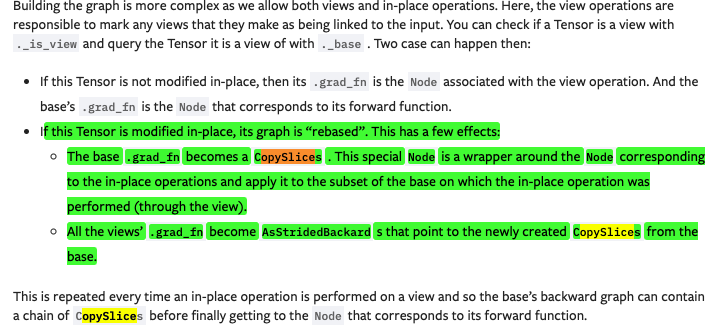

In [ ]:
out.grad_fn

From a user/programer's perspectives, it is suffice to know that this implementation enables a proper backprop graident flow even if we first (1) iniitalize some 'collecting' tensor (like `out` in the example), and assign computed tensors (that exist in some computational graph) as an element of the collecting tensor, and then (2) take a gradient of out (eg. `out.backward()`) will properly compute the weights involving in computing those element tensors. 

---
## Test with `torch.MSELoss`
I need to figure out how `torch.MSELoss`'s reduction works when the `out` and `x` are
more than 4dim, which is the usual case when we have a mini-batch of 3dim `out` (and same for `x`).

In this case, the decoder outputs a 5dim tensor as the mean of the output likelihood model:
- recon: (BS, self.n_samples, c, h, w)


In [ ]:
bs = 1
n_samples = 2 # n_samples of z's per datapoint
c,h,w = 3,4,5
mu_x_pred =  torch.ones((bs, n_samples, c, h, w))
mu_x_pred[0,0] = 0.

# print('===0===')
# print(mu_x_pred[0,0])
# print('===1===')
# print(mu_x_pred[0,1])
print('mu_x_pred: ', mu_x_pred.shape)

In [ ]:
x = torch.zeros((bs,c,h,w))

In [ ]:
x = x[:,None] # Adds a dimension correpsonding to the `n_samples` dimension

In [ ]:
print('target: ', x.shape)

In [ ]:
# compute mseloss
recon_loss = (mu_x_pred - x).pow(2).mean(dim=1).sum(dim=(-3,-2,-1)).mean(dim=0)
recon_loss

In [ ]:
recon_loss_avged_over_samples = (mu_x_pred - x).pow(2).mean(dim=1)
print("recon_loss avged over samples of z's: ")
print(recon_loss_avged_over_samples.shape)

# Now, as usual, take the sum over the pixels
batch_recon_loss = recon_loss_avged_over_samples.sum(dim=(-3,-2,-1))
print("\nbatch of recon_loss for each input datapt: ")
print(batch_recon_loss.shape)

# Now, take the average across the batch
recon_loss = batch_recon_loss.mean(dim=0)
print("\nrecon_loss per datapt, estimated from this batch, with each datapt having n_sample z's: ")
print(recon_loss)

---
## `nn.Module`'s `.to`


In [ ]:
class Net(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, 
                 dtype=torch.float32):
        
        super().__init__()
        self.dtype = dtype

        self.layer1 = nn.Linear(in_dim, h_dim)
        self.layer2 = nn.Linear(h_dim, out_dim)
        self.act_fn = nn.ReLU()
        
        print("Before: ", self.layer1.weight.dtype)
        self.to(self.dtype)
        print("After: ", self.layer1.weight.dtype)

    def forward(self,x):
        x = self.act_fn(self.layer1(x))
        x = self.act_fn(self.layer2(x))
        return x
    


In [ ]:
net = Net(1,10,3)
print("===")
net = Net(1,10,3, dtype=torch.float16)
